<a href="https://colab.research.google.com/github/Ekkydimas/WasteClassificationNeuralNetwork/blob/main/WasteClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Nov 10 10:40:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split



##**Data Gathering and Preprocessing**

In [5]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git

fatal: destination path 'WasteClassificationNeuralNetwork' already exists and is not an empty directory.


In [7]:
# LOAD DATA
DIR = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, image_size=(256, 256)
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, image_size=(256, 256)
)

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Found 5078 files belonging to 9 classes.
Using 4571 files for training.
Found 5078 files belonging to 9 classes.
Using 507 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Other Plastics', 'Paper and Cardboard', 'Plastic', 'Textiles', 'Wood']


##**Model Training**

In [10]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 559ms/step - accuracy: 0.1424 - loss: 1364.0586 - val_accuracy: 0.0848 - val_loss: 1300.0845
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.1466 - loss: 717.1507 - val_accuracy: 0.1065 - val_loss: 1433.8232
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.2042 - loss: 439.0027 - val_accuracy: 0.1223 - val_loss: 1659.0172
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step - accuracy: 0.2256 - loss: 327.8573 - val_accuracy: 0.1341 - val_loss: 1298.7416
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - accuracy: 0.2509 - loss: 262.1114 - val_accuracy: 0.0966 - val_loss: 1425.9828
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.2447 - loss: 234.8869 - val_accuracy: 0.0237 - val_loss: 1063.6580
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 313ms/step - accuracy: 0.2709 - loss: 203.7589 - val_accuracy: 0.0276 - val_loss: 1043.6804
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - accura

In [11]:
model.save("/content/model.h5")
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 128, 128, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 128, 128, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 16)   │            144 │ activation_20[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 128, 128, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            256 │ re_lu_19[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 128, 128, 16)   │              0 │ activation_20[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 128, 128, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 128, 128, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 128, 128, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 4,367,901 (16.66 MB)

 Trainable params: 559,689 (2.14 MB)

 Non-trainable params: 2,688,832 (10.26 MB)

 Optimizer params: 1,119,380 (4.27 MB)

##**Model Evaluation**

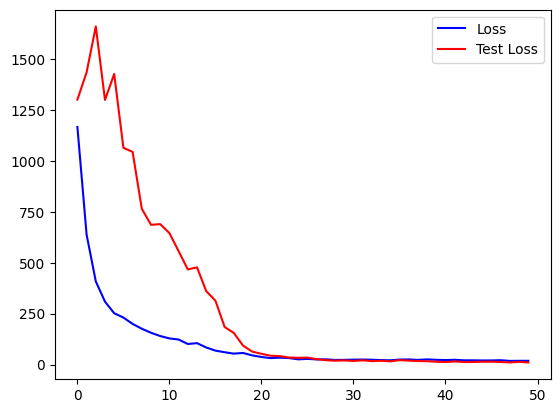

In [12]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

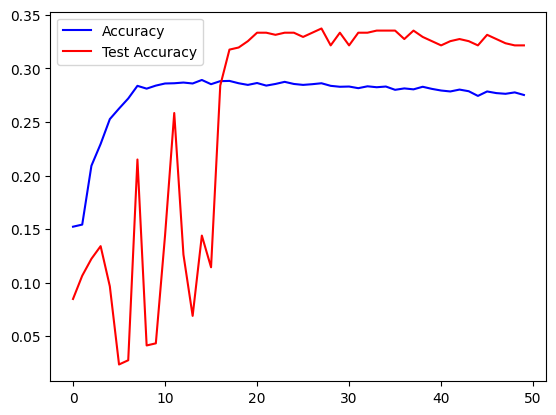

In [13]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

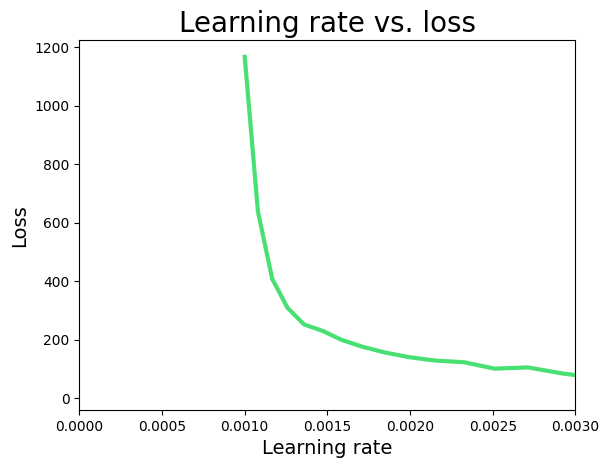

In [14]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

In [13]:
import requests

img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7dbed63f5fd0>

In [1]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/WasteClassificationNeuralNetwork/WasteImagesDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

NameError: name 'plt' is not defined

**Advanced Filter Visualization**

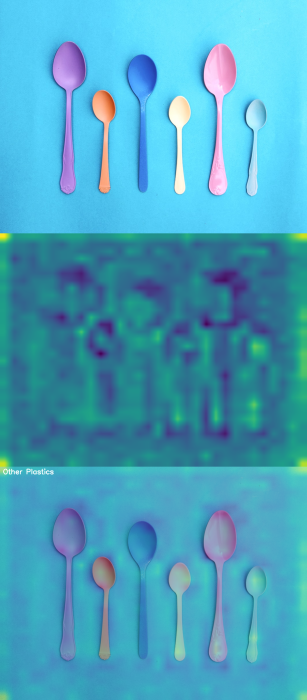

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "/content/img.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)